In [1]:
%matplotlib inline

import pandas as pd
from utils import get_mongo_db
import itertools

Let's first get the MongoDB instance

In [2]:
db = get_mongo_db()

Connecting to MongoDB at localhost:27017...


Let's now compute the number of repositories per language (keeping in mind that the `repositories` collection contains both repositories owned by our Swiss users, but also any repository that they starred. It's thus a pretty big collection).

In [3]:
db.repositories.count()

134092

Let's first do the aggregation manually in Python:

In [4]:
repos = db.repositories.find({ 'language': { '$ne': None } }, { 'language': True })
repos.count()

124254

In [5]:
repos[0]

{'_id': 24002363, 'language': 'JavaScript'}

In [6]:
counts = {}
for repo in repos:
    if repo['language'] not in counts:
        counts[repo['language']] = 0
    counts[repo['language']] += 1

In [7]:
data = [{ 'language': lang, 'count': counts[lang] } for lang in counts]
df = pd.DataFrame(data).set_index('language')
df.sort_values(by='count', ascending=False)[0:10]

,count
language,
JavaScript,26903
Python,14709
PHP,9838
Java,9196
Ruby,9157
C,6004
C++,5702
Objective-C,4519
Shell,4198


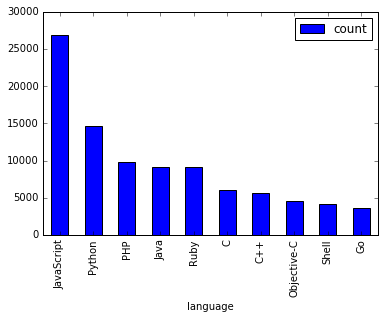

In [8]:
df.sort_values(by='count', ascending=False)[0:10].plot(kind='bar')

Let's now use a potentially more efficient method, using MongoDB's aggregation framework:

In [9]:
from bson.son import SON

In [10]:
pipeline = [
    {
        '$match': {
            'language': { '$ne': None }
        }
    },
    {
        '$group': {
            '_id': '$language',
            'count': { '$sum': 1 }
        }
    },
    {
        '$sort': SON([('count', -1), ('_id', -1)])
    }
]


data = list(db.repositories.aggregate(pipeline))

In [11]:
df = pd.DataFrame(data).rename(columns={ '_id': 'language' }).set_index('language')
df.sort_values(by='count', ascending=False)[0:10]

,count
language,
JavaScript,26903
Python,14713
PHP,9838
Java,9197
Ruby,9169
C,6004
C++,5702
Objective-C,4519
Shell,4202


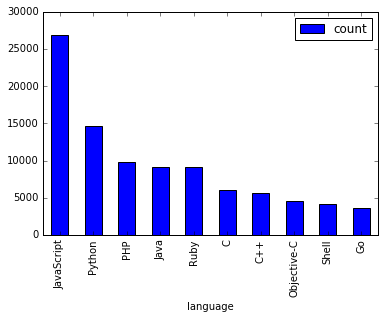

In [12]:
df.sort_values(by='count', ascending=False)[0:10].plot(kind='bar')

Alright, let's now try to retrieve all the Swiss users and their repositories:

In [43]:
res = db.users.find({ 'in_ch': True, 'repositories': { '$ne': None } })

users = []

for user in res:
    repos = db.repositories.find(
        { '_id': { '$in': user['repositories'] } }
    )
    
    users.append({
        '_id': user['_id'],
        'login': user['login'],
        'name': user['name'],
        'location': user['location'],
        'repositories_docs': list(repos)
    })

In [45]:
len(users)

3077

In [46]:
users[1]

{'_id': 183678,
 'location': 'Zürich, Zurich, Switzerland',
 'login': 'Seldaek',
 'name': 'Jordi Boggiano',
 'repositories_docs': [{'_id': 546522,
   'clone_url': 'https://github.com/Seldaek/phergie.git',
   'created_at': datetime.datetime(2010, 3, 4, 12, 46, 24),
   'fork': True,
   'forks_count': 1,
   'full_name': 'Seldaek/phergie',
   'has_downloads': False,
   'has_issues': False,
   'has_pages': False,
   'homepage': 'http://phergie.org',
   'language': 'PHP',
   'name': 'phergie',
   'open_issues': 0,
   'open_issues_count': 0,
   'owner_id': 183678,
   'private': False,
   'size': 324,
   'stargazers_count': 3,
   'watchers_count': 3},
  {'_id': 568030,
   'clone_url': 'https://github.com/Seldaek/Dwoo.git',
   'created_at': datetime.datetime(2010, 3, 18, 10, 40, 47),
   'fork': False,
   'forks_count': 16,
   'full_name': 'Seldaek/Dwoo',
   'has_downloads': True,
   'has_issues': True,
   'has_pages': False,
   'homepage': '',
   'language': 'PHP',
   'name': 'Dwoo',
   'open_i

Let's now try using MongoDB's aggregation framework:

In [47]:
pipeline = [
    {
        '$match': { 'in_ch': True, 'repositories': { '$ne': None } }
    },
    {
        '$lookup': {
            'from': 'repositories',
            'localField': '_id',
            'foreignField': 'owner_id',
            'as': 'repositories_docs'
        }
    },
    {
        '$project': {
            'login': True,
            'name': True,
            'location': True,
            'repositories_docs': True
        }
    }
]

data = list(db.users.aggregate(pipeline))

In [48]:
len(data)

3077

In [49]:
data[1]

{'_id': 183678,
 'location': 'Zürich, Zurich, Switzerland',
 'login': 'Seldaek',
 'name': 'Jordi Boggiano',
 'repositories_docs': [{'_id': 6427443,
   'clone_url': 'https://github.com/Seldaek/ActivDevNoclineBundle.git',
   'created_at': datetime.datetime(2012, 10, 28, 12, 50, 43),
   'fork': True,
   'forks_count': 0,
   'full_name': 'Seldaek/ActivDevNoclineBundle',
   'has_downloads': True,
   'has_issues': False,
   'has_pages': False,
   'homepage': '',
   'language': 'PHP',
   'name': 'ActivDevNoclineBundle',
   'open_issues': 0,
   'open_issues_count': 0,
   'owner_id': 183678,
   'private': False,
   'size': 182,
   'stargazers_count': 4,
   'watchers_count': 4},
  {'_id': 24607470,
   'clone_url': 'https://github.com/Seldaek/alice.git',
   'created_at': datetime.datetime(2014, 9, 29, 18, 29, 20),
   'fork': True,
   'forks_count': 0,
   'full_name': 'Seldaek/alice',
   'has_downloads': True,
   'has_issues': False,
   'has_pages': False,
   'homepage': None,
   'language': None,